In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import json

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import nltk
from nltk import SnowballStemmer
from nltk.corpus import stopwords

import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


from sklearn.utils import shuffle

In [2]:
SHUFFLE_RANDOM_STATE = 42
TRAIN_RANDOM_STATE = 42
SGD_RANDOM_STATE = 42

SGD_MAX_ITER = 1000

TEXT = 'Sentence'
FILTER = 'Entity'
START_TOKEN = 'START'
TOKEN_LEN = 'LEN'
Y_HEADER = 'LABEL'
LABELS = {
    "NEG": 0,
    "SEM": 1,
    "POZ": 2
}

EKEZET_VALTAS_RAGNAL = {
    'a': 'á',
    'e': 'é'
}

In [3]:
# Text processing
URL_RE = 'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}([-a-zA-Z0-9()@:%_+.~#?&/=]*)'
WHITELIST_RE = '[^a-zA-Z0-9íÍöÖüÜóÓőŐúÚáÁéÉűŰ]'

ures = 0

def cleanse(i):
    global ures
    text = dataset[TEXT].iloc[i]
    text = re.sub(URL_RE, ' ', text)
    text = re.sub(WHITELIST_RE, ' ', text)
    text = ' '.join([text.lower()])
    return re.sub(' +', ' ', text)

def delete_empty_rows(dataset):
    ids_to_delete = dataset.index[dataset[TEXT] == ' '].tolist()
    return dataset.drop(ids_to_delete)

In [14]:

# Load and set up data

dataset = pd.read_csv('db/sport_or_e_sport.csv', sep=';', error_bad_lines=False)
dataset = shuffle(dataset, random_state=SHUFFLE_RANDOM_STATE)
dataset.info()

dataset = delete_empty_rows(dataset)
for i  in range(len(dataset.index)):
    dataset[TEXT].iloc[i] = cleanse(i)
    
dataset = delete_empty_rows(dataset)
dataset.head(5)
X = dataset[TEXT].values
y = dataset[Y_HEADER].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=TRAIN_RANDOM_STATE)

C:\Users\Daniel_Janos_Robert\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49954 entries, 7565 to 15795
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence    49954 non-null  object
 1   LABEL       49954 non-null  object
 2   Unnamed: 2  1 non-null      object
dtypes: object(3)
memory usage: 1.5+ MB


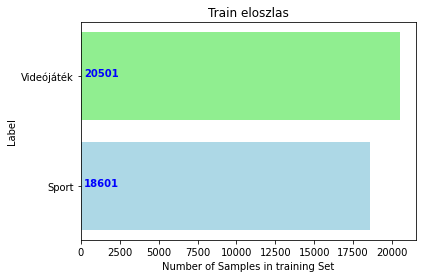

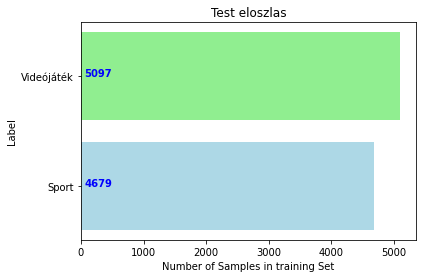

In [5]:
def plot_label_counts(y, title='y labels'):
    unique, counts = np.unique(y, return_counts=True)
    b = dict(zip(unique, counts))
    b_values = [b['SPORT'], b['VIDEÓJÁTÉK']]
    plt.barh(range(len(b)), b_values, align='center', color=['lightblue', 'lightgreen'])
    y_values = ["Sport", "Videójáték"]
    y_axis = np.arange(0, 2, 1)
    plt.yticks(y_axis, y_values)
    plt.title(title)
    plt.xlabel('Number of Samples in training Set')
    plt.ylabel('Label')
    ax = plt.gca()
    for i, v in enumerate(b_values):
        plt.text(ax.get_xlim()[1]/100, i, str(v), color='blue', fontweight='bold')
    plt.show()

plot_label_counts(y_train, 'Train eloszlas')
plot_label_counts(y_test, 'Test eloszlas')

In [6]:
def evaluate(predict, labels):
    print('Classification report:')
    print(classification_report(labels, predict))
    print('Accuracy:')
    print(accuracy_score(labels, predict))

    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(labels, predict, labels=['SPORT', 'VIDEÓJÁTÉK']),
                         index=[i for i in ['SPORT', 'VIDEÓJÁTÉK']],
                         columns=[i for i in ['SPORT', 'VIDEÓJÁTÉK']],)
    plt.figure(figsize=(10,7))
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    plt.show()

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel_Janos_Robert\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:

all_stopwords = []

def create_corpus_by_dataset(sentences):
    global all_stopwords
    corpus = []
    for sen in sentences:
        all_stopwords = stopwords.words('hungarian')
        whitelist = ["ne", "nem", "se", "sem"]
        sentence = [word for word in sen.split() if (word not in all_stopwords or word in whitelist)
                 and len(word) > 1]
        ps = SnowballStemmer('hungarian')
        sentence = [ps.stem(word) for word in sentence]
        sentence = ' '.join(sentence)
        corpus.append(sentence)

    return corpus

X_train_clean = create_corpus_by_dataset(X_train)
print(X_train_clean)
X_test_clean = create_corpus_by_dataset(X_test)

['száz év huny gill ferenc magyar labdarúgás kiemelkedő al labdarúgó válogatot első szövetség kapitány', '', 'jap szus an moder videojáte ipar megerőszakolós dating sim otthon micsod', 'zlat ibrahimovic hihetetl pal', 'játszot közület ps3 on xbox 360 on', 'nem múl balh est', 'szeg is erősorren élmezőny', 'nyolcgólos döntetlen játszot aj sopr re nyer mezőköves balmazújváros elérhető nb ii es összefoglaló mlsz tv', 'magyar válogatot játékos olasz élvonal áda bologn folytat', 'jonath caller fantasztikus rabonás gól boc juniors quilmes meccs', 'rendel elő pc re the elder scrolls onlin ajánde explorers csomag alapváltozat imperial edit kiadás napos kor hozzáférés biztosí kat id', 'jobb ha való működn', 'hangulat nem panasz magyar válogatott', 'casillas xav legenda', 'nem néz rossz lehetn jobb', 'nem mindennap üzl', 'palmer luckey is kifejtett vélemény playstat vr ral kapcsolat', 'baj', 'épp tartott első edzés mi eln is távozot', 'bizonyos eset töröln kellen találkozó', 'elitedangerous jövő 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.002, ngram_range=(1,3)) #ngram (1-3)
x_train_model = cv.fit_transform(X_train_clean)

In [12]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(random_state=SGD_RANDOM_STATE, max_iter=SGD_MAX_ITER, learning_rate='constant',
                           eta0=0.01)
classifier.fit(x_train_model, y_train)

SGDClassifier(eta0=0.01, learning_rate='constant', random_state=42)

Classification report:
              precision    recall  f1-score   support

       SPORT       0.83      0.93      0.88      4679
  VIDEÓJÁTÉK       0.93      0.83      0.88      5097

    accuracy                           0.88      9776
   macro avg       0.88      0.88      0.88      9776
weighted avg       0.88      0.88      0.88      9776

Accuracy:
0.8776595744680851
Confusion matrix:


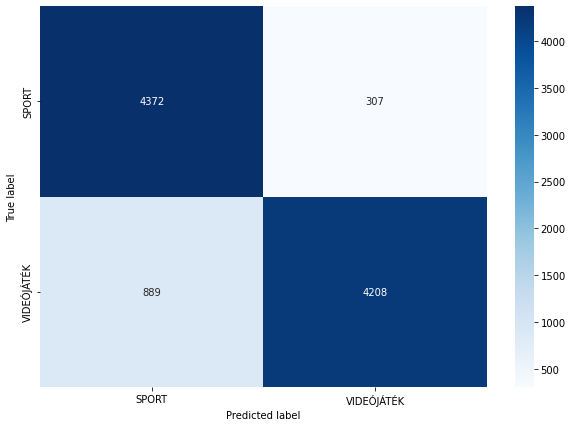

In [13]:
x_dev_model = cv.transform(X_test_clean)

dev_predict = classifier.predict(x_dev_model)

evaluate(dev_predict, y_test)